In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from tune_model import tune #function to tune hyperparameters

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

In [3]:
# load the dataset
data = pd.read_csv('../../data/definitive_dataset.csv')

# convert date columns to date with no time
data['date'] = pd.to_datetime(data['date'])

In [4]:
# load the features as pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    features = pkl.load(f)

In [5]:
# drop rows with missing target value
data.dropna(subset=['target'], inplace=True)

In [7]:
# define starting dates for the periods
starting_dates = ['2008-01-01', '2010-01-01', '2012-01-01', '2014-01-01', '2016-01-01', '2018-01-01']

# define the model
model = XGBClassifier()

# define the hyperparameters to tune
hyperparameters = {
    'n_estimators': [1000],
    'max_depth': [11],
    'min_child_weight': [1],
    'gamma': [0],
    'eta': [0.3],
    'alpha': [1.5],
}

# define a multi metric to use in the tuning
scoring = {
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'F1': 'f1',
    'Precision': 'precision',
    'Recall': 'recall'
}

In [102]:
# tune a model for each starting date
for start_date in starting_dates:

    # convert the start date to datetime
    start_date = pd.to_datetime(start_date)
    
    # define the end date
    end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

    # convert the dates to strings
    start_date_str = str(start_date.date())
    end_date_str = str(end_date.date()) 

    print(f'Training model for the period {start_date_str} to {end_date_str}...')
    
    # subset the data to the period of interest
    training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

    # find the selected features for the period of interest
    training_features = features[start_date]
    print(f'Number of features: {len(training_features)}')

    initial_length = len(training_data)

    # remove outliers from features
    for feature in training_features:
        q1 = training_data[feature].quantile(0.25)
        q3 = training_data[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 3.5*iqr
        upper_bound = q3 + 3.5*iqr
        training_data = training_data[(training_data[feature] >= lower_bound) & (training_data[feature] <= upper_bound)]
    print(f'Length of training data: {len(training_data)}, original length: {initial_length}, removed {initial_length - len(training_data)} outliers.')

    X = training_data[training_features].copy()
    y = training_data['target'].copy()


    # find the scale_pos_weight
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

    # add the scale_pos_weight to the hyperparameters
    hyperparameters['scale_pos_weight'] = [scale_pos_weight]

    # tune the model
    best_params, best_model = tune(X=X, y=y, space=hyperparameters,
                                   model=model, search_type='grid', 
                                   n_splits=2, n_repeats=1, scoring=scoring,
                                   refit='AUC')

    # save the best model
    with open(f'../../models/xgb_{start_date_str}.pkl', 'wb') as f:
        pkl.dump(best_model, f)
    
    print('-'*50, '\n')


Training model for the period 2008-01-01 to 2009-10-02...
Number of features: 33
Length of training data: 109413, original length: 272473, removed 163060 outliers.
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best Score (AUC): 0.9244303395201674
Accuracy: 0.8468006503787948
F1: 0.8554276846541559
Precision: 0.8548082817019791
Recall: 0.8560626985223035

Best Hyperparameters:
alpha: 1.5
eta: 0.3
gamma: 0
max_depth: 11
min_child_weight: 1
n_estimators: 1000
scale_pos_weight: 0.8887757215854164

-------------------------------------------------- 

Training model for the period 2010-01-01 to 2011-10-02...
Number of features: 34
Length of training data: 115406, original length: 271016, removed 155610 outliers.
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best Score (AUC): 0.9103690378634695
Accuracy: 0.8347312964663882
F1: 0.8609060731183011
Precision: 0.8540695463312478
Recall: 0.867863454068371

Best Hyperparameters:
alpha: 1.5
eta: 0.3
gamma: 0
max_depth: 11

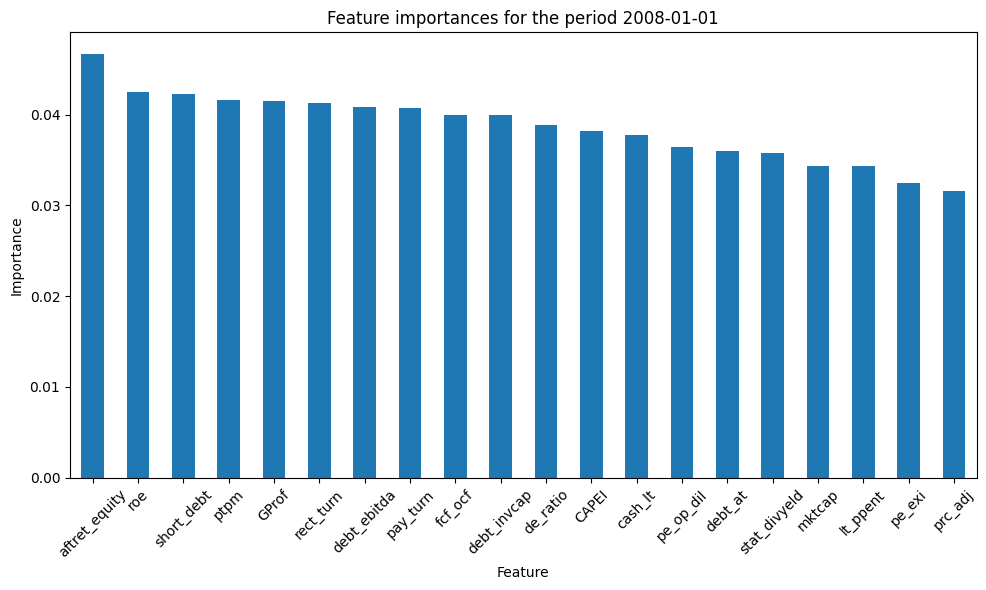

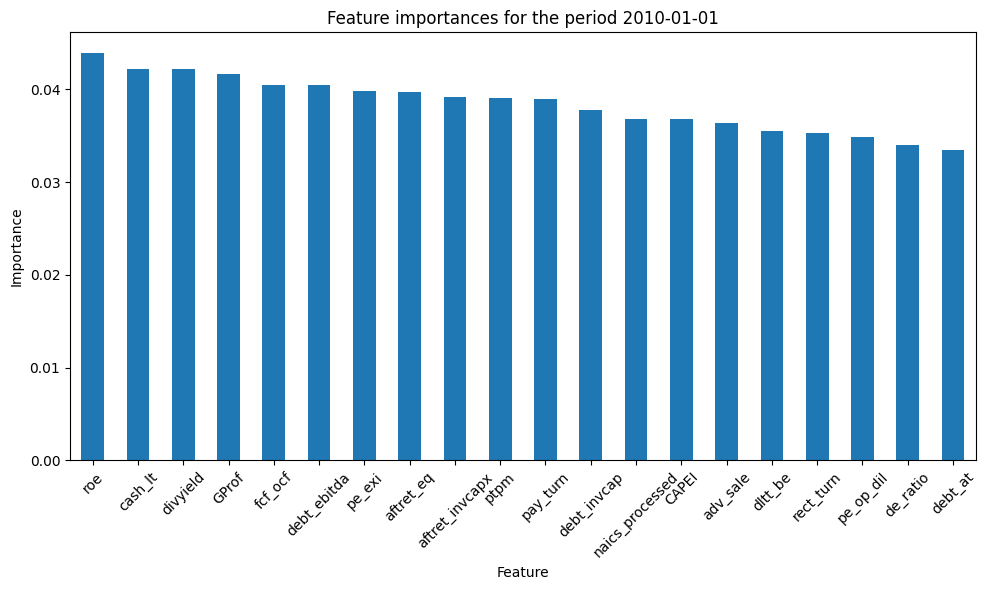

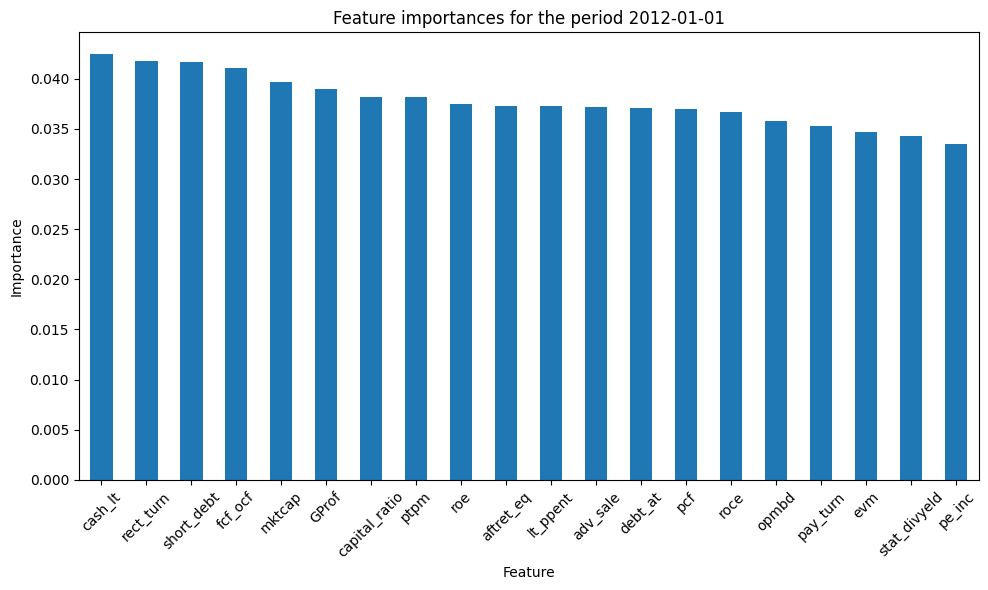

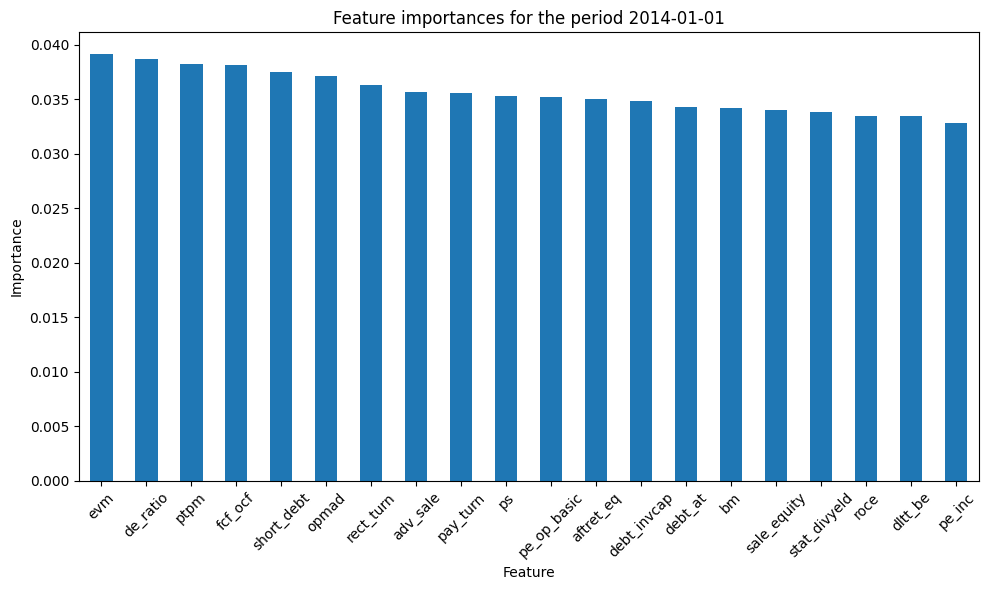

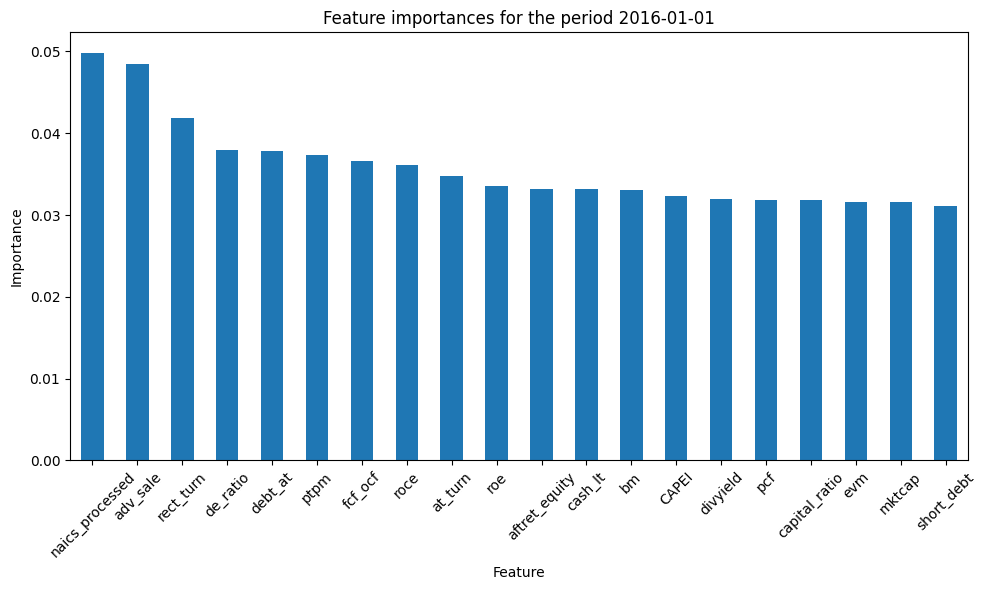

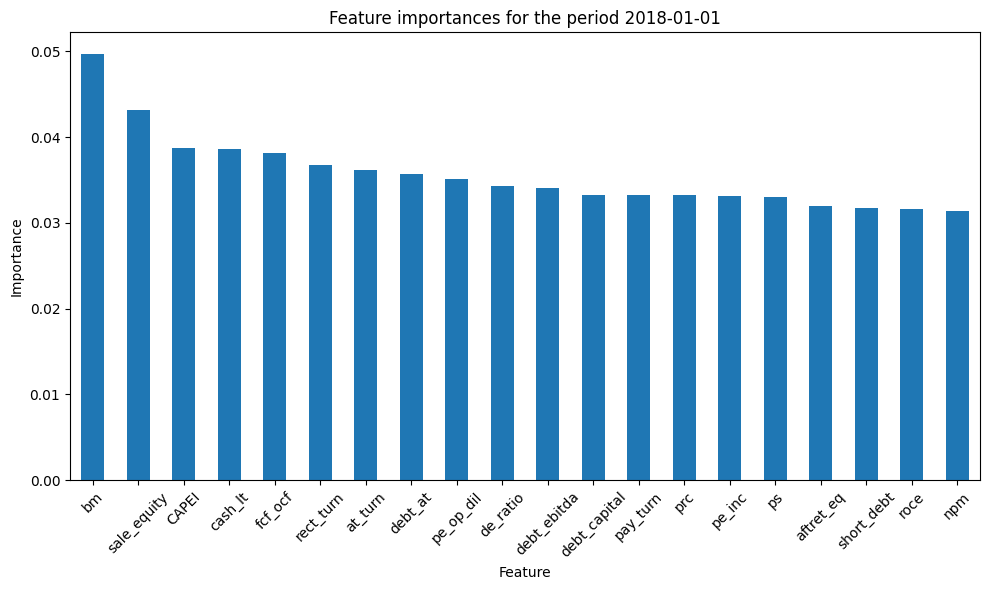

In [8]:
for start_date in starting_dates:

    # load the model
    with open(f'../../models/xgb_{start_date}.pkl', 'rb') as f:
        model = pkl.load(f)

    feature_importances = model.feature_importances_
    feature_names = model.get_booster().feature_names

    feature_importances = pd.Series(feature_importances, index=feature_names)
    feature_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    feature_importances[:20].plot(kind='bar')
    plt.title(f'Feature importances for the period {start_date}')
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()